<a href="https://colab.research.google.com/github/yooste/SOLUX_summer_data/blob/master/4%EC%A3%BC%EC%B0%A8/bike_sharing_demand_ml_using_various_models_0818.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.testing as tm

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

plt.rc('font', family='NanumBarunGothic')

In [4]:
train = pd.read_csv('data/train.csv', parse_dates=['datetime'])
train.shape

(10886, 12)

In [5]:
test = pd.read_csv('data/test.csv', parse_dates=['datetime'])
test.shape

(6493, 9)

In [6]:
# feature로 사용할 데이터들만 데이터프레임에 담아준다.
train['year']=train['datetime'].dt.year
train['month']=train['datetime'].dt.month
train['hour']=train['datetime'].dt.hour
train['dayofweek']=train['datetime'].dt.dayofweek
train.shape
# 12개 column에서 16개로 늘어남

(10886, 16)

In [7]:
test['year']=test['datetime'].dt.year
test['month']=test['datetime'].dt.month
test['hour']=test['datetime'].dt.hour
test['dayofweek']=test['datetime'].dt.dayofweek
test.shape
# 9개 column에서 13개로 늘어남

(6493, 13)

In [8]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경해준다.
categorical_feature_names = ['season','holiday','workingday','weather','dayofweek',
                             'month','year','hour']

In [9]:
for var in categorical_feature_names:
  train[var] = train[var].astype('category')
  test[var] = test[var].astype('category')

In [10]:
# 사용할 feature 선택하기
feature_names = ['season','weather','temp','atemp','humidity',
                 'year','hour','dayofweek','holiday','workingday']

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [11]:
# feature_names로 새로운 데이터프레임 X_train 만들기
X_train = train[feature_names]

print(X_train.shape)

X_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


In [12]:
# feature_names로 새로운 데이터프레임 X_test 만들기
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,3,0,1
2,1,1,10.66,13.635,56,2011,2,3,0,1
3,1,1,10.66,12.880,56,2011,3,3,0,1
4,1,1,10.66,12.880,56,2011,4,3,0,1


In [13]:
# label 데이터를 가져와서 y_train에 담아주기
label_name = 'count'

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [14]:
from sklearn.metrics import make_scorer

# bike sharing demand의 평가방식인 RMSLE 정의
def rmsle(predicted_values, actual_values, convertExp=True):
  if convertExp:
    predicted_values = np.exp(predicted_values),
    actual_values = np.exp(actual_values)

  # 넘파이로 배열 형태로 바꿔준다.
  predicted_values = np.array(predicted_values)
  actual_values = np.array(actual_values)

  # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
  log_predict = np.log(predicted_values + 1)
  log_actual = np.log(actual_values + 1)

  # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
  difference = log_predict - log_actual
  difference = np.square(difference)

  # 평균을 낸다.
  mean_difference = difference.mean()

  # 다시 루트를 씌운다.
  score = np.sqrt(mean_difference)

  return score

# **선형회귀 모델 Linear Regression Model**

  - 선형회귀 또는 최소제곱법은 가장 간단하고 오래된 회귀용 선형 알고리즘
  - 선형회귀는 예측과 훈련 세트에 있는 타깃 y 사이의 평균제곱오차(MSE)를 최소화하는 파라미터 w와 b를 찾는다.
  - 매개변수가 없는 것이 장점이지만, 모델의 복잡도를 제어할 수 없다는 단점이 있다.
  - 아래 위키피디아에서 가져 온 그래프에서 파란선이 선형회귀 모델을 나타내고 빨간점들이 훈련데이터를 나타낸다.

  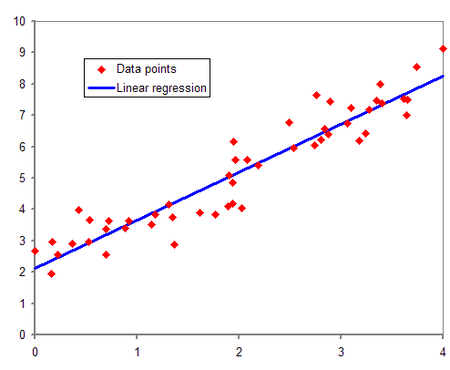

In [16]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore',category=DeprecationWarning)

# 선형회귀 모델을 초기화
lModel = LinearRegression()

# 모델을 학습시킨다.
y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

# 예측하고 정확도를 평가한다.
preds = lModel.predict(X_train)
print('RMSLE Value For Linear Regression: ',
      rmsle(np.exp(y_train_log), np.exp(preds), False))

RMSLE Value For Linear Regression:  0.9803697923313522


# **릿지 Regularization Model - Ridge**
  - 회귀를 위한 선형모델
  - 가중치(w)의 모든 원소가 0에 가깝게 만들어 모든 피처가 주는 영향을 최소화(기울기를 작게 만듦)
  - Regularization(규제)는 오버피팅(과대적합)이 되지 않도록 모델을 강제로 제한한다는 의미
  - max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9803697902780834


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


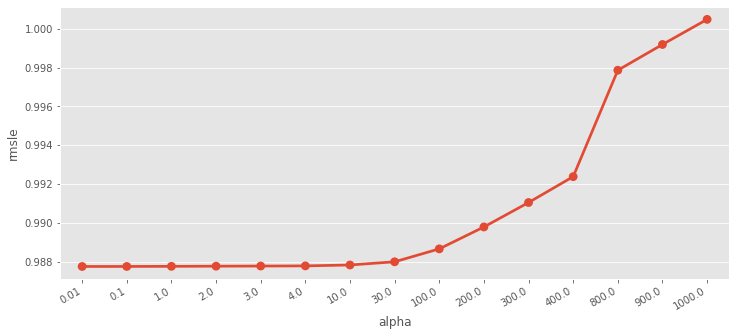

In [18]:
ridge_m_ = Ridge()
ridge_params_ = {'max_iter':[3000], 'alpha':[0.01,0.1,1,2,3,4,10,30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
# GridSearchCV를 통해 최적의 alpha 값을 찾는다.
grid_ridge_m = GridSearchCV(ridge_m_,
                            ridge_params_,
                            scoring = rmsle_scorer,
                            cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit(X_train, y_train_log)  # 학습을 시킴
preds = grid_ridge_m.predict(X_train)
print(grid_ridge_m.best_params_)
print('RMSLE Value For Ridge Regression: ', rmsle(np.exp(y_train_log),np.exp(preds), False))

# GridSearchCV 한 값을 시각화해보기
fig, ax = plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge_m.cv_results_)
df['alpha']=df['params'].apply(lambda x:x['alpha'])
df['rmsle'] = df['mean_test_score'].apply(lambda x:-x)

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df, x='alpha', y='rmsle', ax=ax)

# **라쏘 Regularization Model - Lasso**
  - 선형회귀의 Regularization(규제)를 적용하는 대안
  - 계수를 0에 가깝게 만드려고 하며 이를 L1규제라고 하며, 어떤 계수는 0이 되기도 하는데 이는 완전히 제외하는 피처가 생긴다는 의미다.
  - 피처 선택이 자동으로 이루어진다고도 볼 수 있다.
  - alpha 값의 기본 값은 1.0이며, 과소 적합을 줄이기 위해서는 이 값을 줄여야 한다.
  - 그리드 서치로 아래 라쏘모델을 실행했을 때 베스트 알파값은 0.0025
  - max_iter(반복 실행하는 최대횠수)는 3000을 넣어주었다.

{'alpha': 0.00125, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9803727821457648


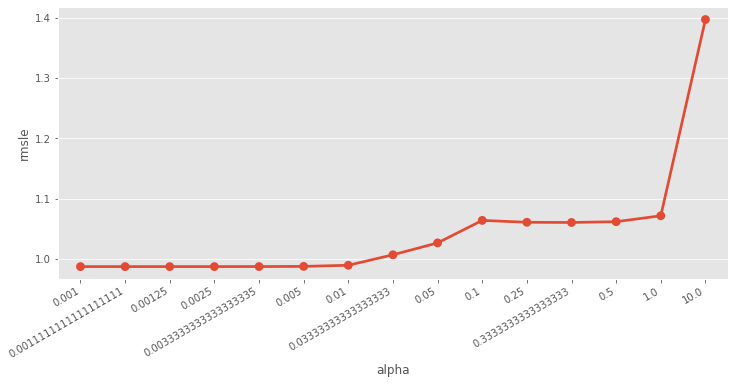

In [19]:
lasso_m_ = Lasso()

alpha = 1/np.array([0.1,1,2,3,4,10,20,30,100,200,300,400,800,900,1000])
lasso_params_ = {'max_iter':[3000], 'alpha':alpha}

# GridSearchCV로 최적의 alpha 값 찾기
grid_lasso_m = GridSearchCV(lasso_m_, lasso_params_, scoring=rmsle_scorer, cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit(X_train, y_train_log) # X_train, y_train_log를 이용하여 학습시킴
preds = grid_lasso_m.predict(X_train)
print(grid_lasso_m.best_params_)  # best 값을 찾아서 출력
print('RMSLE Value For Lasso Regression: ', rmsle(np.exp(y_train_log), np.exp(preds), False))

fig, ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_lasso_m.cv_results_)
df['alpha']=df['params'].apply(lambda x:x['alpha'])
df['rmsle'] = df['mean_test_score'].apply(lambda x:-x)

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df, x='alpha', y='rmsle', ax=ax)

# **앙상블모델 - 랜덤포레스트**

**Ensemble Models - Random Forest**

In [26]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log), np.exp(preds), False)
print('RMSLE Value For Random Forest: ', score)

RMSLE Value For Random Forest:  0.10772368549696712


# **앙상블 모델 - 그라디언트 부스트**

**Ensemble Model - Gradient Boost**

  - 여러 개의 결정트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
  - 회귀와 분류에 모두 사용할 수 있음
  - 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
  - 무작위성이 없고 강력한 사전 가지치기가 사용 됨
  - 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
  - learning_rate: 오차를 얼마나 강하게 보정할 것인지를 제어
  - n_estimator의 값을 키우면 앙상블에 트리가 더 많이 추가되어 모델의 복잡도가 커지고 훈련세트에서의 실수를 바로잡을 기회가 많아지지만 너무 크면 모델이 복잡해지고 오버피팅(과대적합)이 될 수 있다.
  - max_depth(max_leaf_nodes) 복잡도를 너무 높이지 말고 트리의 길이가 5보다 깊어지지 않게 한다.

In [32]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log), np.exp(preds), False)
print('RMSLE Value For Gradient Boost: ', score)

RMSLE Value For Gradient Boost:  0.21357403727249372


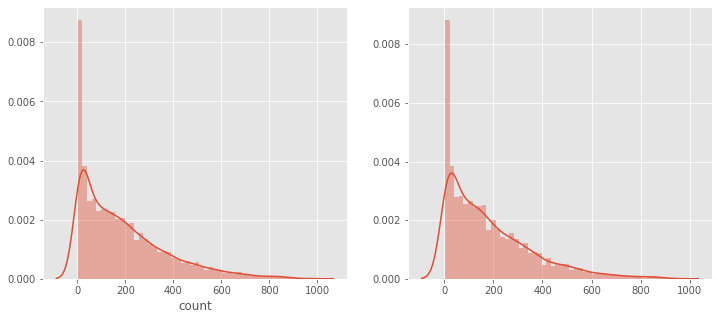

In [27]:
predsTest = rfModel.predict(X_test) # 점수가 가장 높게 나온 rfModel로 새로운 predsTest만들기
# train과 predsTest 비교하여 시각화하기
fig, (ax1,ax2)=plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train, ax=ax1, bins=50)
sns.distplot(np.exp(predsTest), ax=ax2, bins=50)

# **Submit**

In [28]:
submission = pd.read_csv('data/sampleSubmission.csv')
submission

# 학습시킬 때 log를 씌웠기 때문에 다시 지수를 취해주고 count에 넣는다.
submission['count'] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.633437
1,2011-01-20 01:00:00,5.735238
2,2011-01-20 02:00:00,3.274010
3,2011-01-20 03:00:00,4.679376
4,2011-01-20 04:00:00,3.849912


**rfModel로 제출할 때**

In [29]:
# rfModel로 제출할 때
submission.to_csv('data/Score_{0:.5f}_submission.csv'.format(score), index=False)

In [30]:
218/3242

0.06724244293645898

**gbm으로 제출할 때**

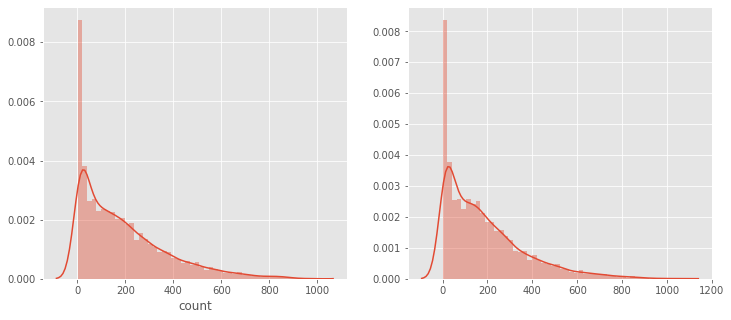

In [31]:
predsTest = gbm.predict(X_test) # 가장 높은 점수는 아니지만 gbm을 통한 점수는 몇점인지 알아보기
# train과 predsTest 비교하여 시각화하기
fig, (ax1,ax2)=plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train, ax=ax1, bins=50)
sns.distplot(np.exp(predsTest), ax=ax2, bins=50)

In [34]:
# gbm으로 제출할 때
submission.to_csv('data/Score_{0:.5f}_submission.csv'.format(score), index=False)

In [35]:
218/3242

0.06724244293645898